# 1. Library Download and Load

In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece
!pip install bertviz

     |████████████████████████████████| 3.1 MB 15.1 MB/s 
     |████████████████████████████████| 3.3 MB 58.0 MB/s 
     |████████████████████████████████| 59 kB 9.6 MB/s 
     |████████████████████████████████| 895 kB 51.3 MB/s 
     |████████████████████████████████| 596 kB 55.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.0 MB 12.8 MB/s 
     |████████████████████████████████| 132 kB 74.1 MB/s 
     |████████████████████████████████| 829 kB 50.0 MB/s 
     |████████████████████████████████| 329 kB 35.9 MB/s 
     |████████████████████████████████| 1.1 MB 48.8 MB/s 
     |████████████████████████████████| 160 kB 71.9 MB/s 
     |████████████████████████████████| 192 kB 73.9 MB/s 
     |████████████████████████████████| 271 kB 62.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=dccb7ba2c815

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path # 파일시스템의 경로를 단순한 문자열이 아닌 객체로 다루게 하는 것
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer
)
from tqdm.auto import tqdm
from bertviz import head_view

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import gc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [ ]:
pl.seed_everything(42)

from google.colab import drive
drive.mount('/content/drive')

Global seed set to 42


Mounted at /content/drive


## 1.2 개발 환경(OS) 및 라이브러리 버전 기재

### 개발 환경 : 구글 코랩(Google Colab)

## 라이브러리 버전
  

In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
aiohttp                       3.7.4.post0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 3.0.1
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bertviz                       1.2.0
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
boto3 

# 2. 데이터 및 전처리 코드

In [ ]:
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/LG_project/data"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")

with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())



with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [ ]:
train = pd.DataFrame(columns=['uid', 'title', 'region', 'context', 'summary'])
uid = 1000
for data in TRAIN_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        train.loc[uid, 'uid'] = uid
        train.loc[uid, 'title'] = data['title']
        train.loc[uid, 'region'] = data['region']
        train.loc[uid, 'context'] = context[:-1]
        train.loc[uid, 'summary'] = data['label'][agenda]['summary']
        uid += 1

test = pd.DataFrame(columns=['uid', 'title', 'region', 'context'])
uid = 2000
for data in TEST_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        test.loc[uid, 'uid'] = uid
        test.loc[uid, 'title'] = data['title']
        test.loc[uid, 'region'] = data['region']
        test.loc[uid, 'context'] = context[:-1]
        uid += 1



train['total'] = train.title + ' ' + train.region + ' ' + train.context
test['total'] = test.title + ' ' + test.region + ' ' + test.context

In [ ]:
train_df = train[['total', 'summary']].reset_index().drop('index', axis='columns')

In [ ]:
train_df.head(2)

,total,summary
0,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.
1,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.


In [ ]:
class NewSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 150):

        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['total']

        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = tokenizer(
            data_row['summary'],
            max_length=self.summary_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()

        )

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
            self,
            train_df: pd.DataFrame,
            test_df: pd.DataFrame,
            tokenizer: T5Tokenizer,
            batch_size: int = 5,
            test_max_token_len: int = 512,
            summary_max_token_len: int = 150
    ):

        super(NewsSummaryDataModule, self).__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = test_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = NewSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

# 3. Tokenizer Load



In [ ]:
MODEL_NAME = 'digit82/kolang-t5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/926k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [ ]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['total']))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)

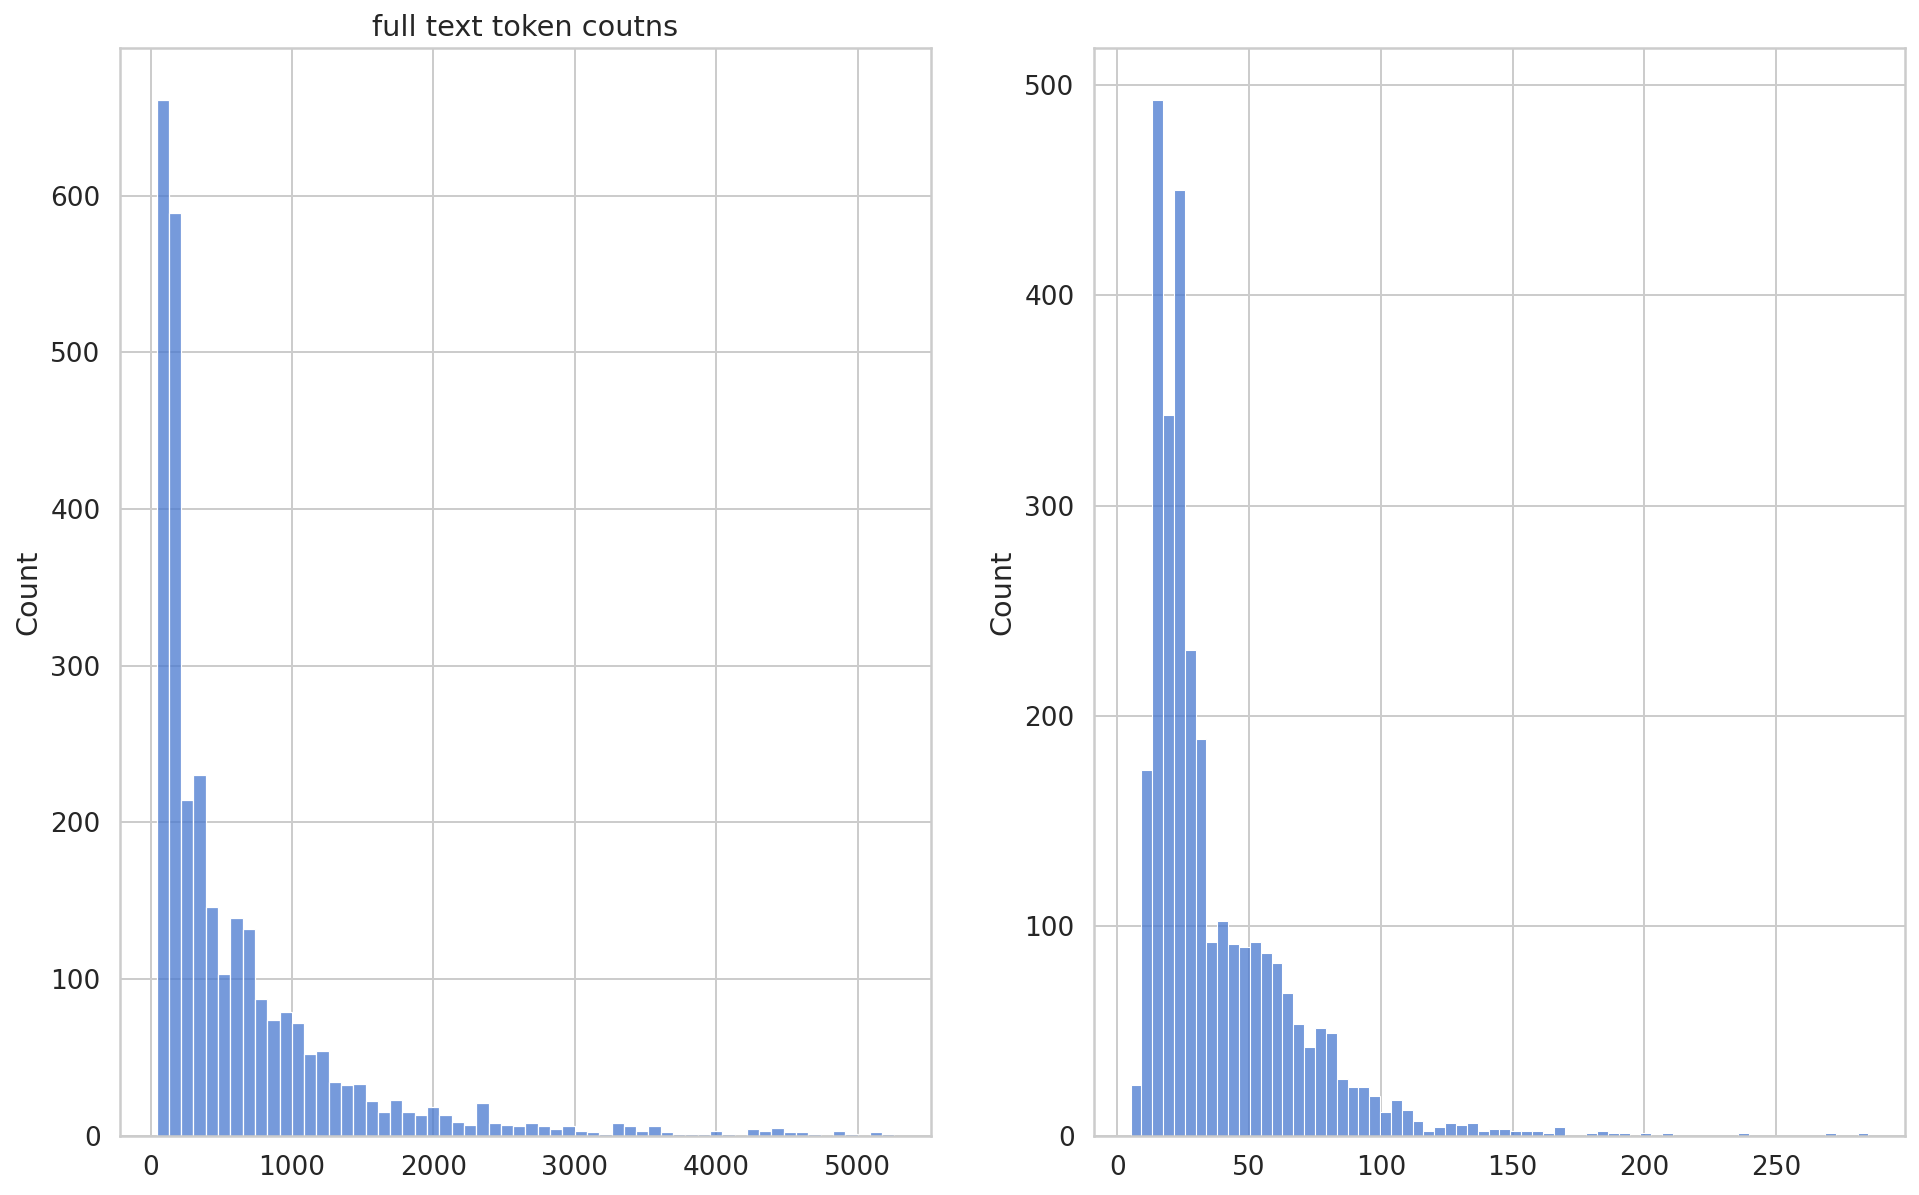

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token coutns')
sns.histplot(summary_token_counts, ax=ax2)

# 4. Model Training

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 5

In [ ]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME ,output_attentions=True ,return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)

        return loss


    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.00005) # 0.0001 -> 0.00001-> 0.00005 -> 0.0001 -> 0.00005 

In [ ]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/859M [00:00<?, ?B/s]

In [ ]:
logger = TensorBoardLogger("lightning_logs", name='news-summary')

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_callback = ModelCheckpoint(
    filename="/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
f_count = 1
for train_index, test_index in skf.split(train_df.total, train_df.summary):
  trainer = pl.Trainer(
    # logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30)

  print('Fold : ' + str(f_count))
  data_module = NewsSummaryDataModule(train_df.iloc[train_index], train_df.iloc[test_index], tokenizer)
  trainer.fit(model, data_module)
  f_count = f_count + 1
  gc.collect()
  if f_count == 4:
    break
  

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold : 1



  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 225 M 
-----------------------------------------------------
225 M     Trainable params
0         Non-trainable params
225 M     Total params
900.744   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 478: val_loss reached 1.41043 (best 1.41043), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint-v31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 957: val_loss reached 1.11360 (best 1.11360), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint-v31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1436: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1915: val_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold : 2



  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 225 M 
-----------------------------------------------------
225 M     Trainable params
0         Non-trainable params
225 M     Total params
900.744   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 478: val_loss reached 0.66714 (best 0.66714), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint-v31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 957: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1436: val_loss reached 0.63983 (best 0.63983), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint-v31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 2394: val_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold : 3



  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 225 M 
-----------------------------------------------------
225 M     Trainable params
0         Non-trainable params
225 M     Total params
900.744   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 478: val_loss reached 0.22650 (best 0.22650), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint-v31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 957: val_loss reached 0.20201 (best 0.20201), saving model to "/content/drive/MyDrive/Colab Notebooks/LG_project/data/best-checkpoint-v31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1436: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1915: val_loss was not in top 1


# 5. Model Inference

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
) 
trained_model.freeze()


In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2, # 5로 늘렸으나 점수가 떨어짐
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [ ]:
sample_row = test.iloc[1]
text = sample_row['total']
model_summary = summarizeText(text)
text


'제235회    본회의 제1차(2012.06.21.) 음성 의사일정 제1항, 음성군의회 제235회 제1차 정례회 회기결정의 건을 상정합니다. 음성군의회 제235회 제1차 정례회 회기는 「음성군의회 회기와 그 운영 등에 관한 조례」제4조제1항의 규정과 의원님들께서 사전에 협의하여 주신 대로 2012년 6월 21일부터 6월 28일까지 8일간 하고자 합니다. 그리고 이번 제1차 정례회 주요의사일정은 환경분야 현지확인 특위 구성의 건, 주요사업 현지확인 결과 보고의 건과 조례안 2건, 2011년도 예비비 지출 승인안, 2011회계 세입ㆍ세출결산 승인안, 2012년도 하반기 군정주요업무 계획 보고 등이 있습니다. 그러면 배부하여 드린 유인물과 같이 의사일정을 결정하고자 하는데, 의원 여러분! 이의가 없으신지요? (「없습니다」하는 의원 있음) 이의가 없으므로 가결되었음을 선포합니다.'

In [ ]:
model_summary

'음성군의회 제235회 제1차 정례회 회기는 2012년 6월 21일부터 6월 28일까지 8일간으로 가결됨.'

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LG_project/data/sample_submission.csv')

In [ ]:
for i, j in enumerate(tqdm(test.total)):
  submission.loc[i, 'summary'] = summarizeText(j)


  0%|          | 0/506 [00:00<?, ?it/s]

In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/LG_project/data/dacon_LG_private.csv', index=False)